# Working with TRIS Data # 
This notebook attempts to visualize the TRIS data, replicate some of their methods, and look at disk/halo models that are consistent with the galactic component of their data

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import healpy as hp
import emcee
from scipy import stats
import corner


from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u

import ModelDefinitions as MD
import LogProb as LP
import const as const
import TRIS_vals as tris
from const import *
from TRIS_vals import *
import importlib
importlib.reload(LP);
importlib.reload(MD);
importlib.reload(const);
importlib.reload(tris);

In [2]:
# Load two lowest bands from TRIS data, 0.6 GHz and 0.8 GHz

TRIS600txt = np.loadtxt('TRIS_absolute_600.txt', dtype=str)
TRIS600_ra = TRIS600txt[:,0]
TRIS600_Tb = np.float_(TRIS600txt[:,1])
TRIS600_Tbsig = np.float_(TRIS600txt[:,2])

TRIS820txt = np.loadtxt('TRIS_absolute_820.txt', dtype=str)
TRIS820_ra = TRIS820txt[:,0]
TRIS820_Tb = np.float_(TRIS820txt[:,1])
TRIS820_Tbsig = np.float_(TRIS820txt[:,2])

In [3]:
# Create a SkyCoord object to turn RA and Dec into galactic coords

sc600 = SkyCoord(ra=TRIS600_ra, dec=42.0, unit=(u.hourangle,u.deg), frame='icrs')
sc820 = SkyCoord(ra=TRIS820_ra, dec=42.0, unit=(u.hourangle,u.deg))

sc600_gal = sc600.galactic
sc600_idx = hp.ang2pix(NSIDE_dg, sc600_gal.l.value, sc600_gal.b.value, lonlat=True)

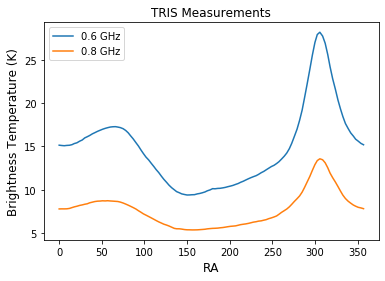

In [4]:
# Plot brightness temperature as function of RA for both bands

plt.plot(sc600.ra, TRIS600_Tb, label='0.6 GHz')
plt.plot(sc820.ra, TRIS820_Tb, label='0.8 GHz')
plt.title('TRIS Measurements', fontsize=12)
plt.xlabel('RA', fontsize=12)
plt.ylabel('Brightness Temperature (K)', fontsize=12)
plt.legend()
plt.savefig('notes/TRIS_Tb.jpg')

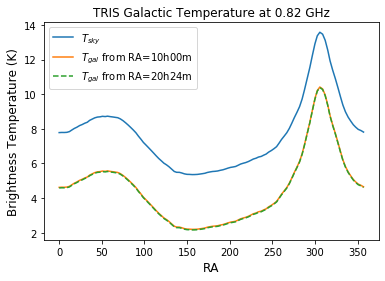

In [5]:
# Calcualte galactic temperature for 0.6 GHz given two reference positions and plot
aref1 = np.ravel(np.where(TRIS820_ra=='10h00m'))
Tgal_ref1 = 2.21
Tsky_ref1 = TRIS820_Tb[aref1]
Tgal1 = TRIS820_Tb - Tsky_ref1 + Tgal_ref1

aref2 = np.ravel(np.where(TRIS820_ra=='20h23m'))
Tgal_ref2 = 10.38
Tsky_ref2 = TRIS820_Tb[aref2]
Tgal2 = TRIS820_Tb - Tsky_ref2 + Tgal_ref2

plt.plot(sc820.ra, TRIS820_Tb, label='$T_{sky}$')
plt.plot(sc820.ra, Tgal1,'-', label=('$T_{gal}$' + ' from RA=10h00m'))
plt.plot(sc820.ra, Tgal2,'--', label=('$T_{gal}$' + ' from RA=20h24m'))
plt.title('TRIS Galactic Temperature at 0.82 GHz', fontsize=12)
plt.xlabel('RA', fontsize=12)
plt.ylabel('Brightness Temperature (K)', fontsize=12)
plt.legend();
#plt.savefig('notes/TRIS_Tgal.jpg')


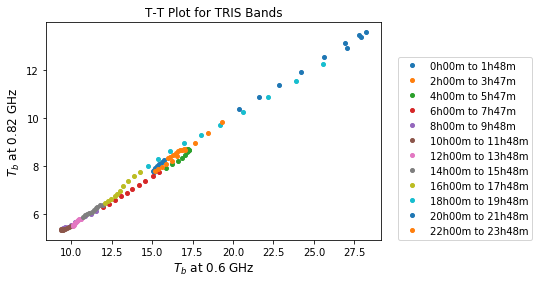

In [6]:
### Plot TT plot, color coded by RA

n = 10

# cmap_int = 0.9/n
# cmap = cm.get_cmap('viridis')

for i in np.arange((len(TRIS600_ra)/n)):
    i = int(i)
    plt.plot(TRIS600_Tb[n*i:(n*(i+1))], TRIS820_Tb[n*i:(n*(i+1))], '.', label=(str(TRIS600_ra[n*i]) +' to '+str(TRIS600_ra[n*(i+1)-1])), markerSize='8')
    
plt.legend(loc=(1.05,0));
plt.title('T-T Plot for TRIS Bands', fontSize=12);
plt.xlabel('$T_{b}$ at 0.6 GHz', fontSize=12);
plt.ylabel('$T_{b}$ at 0.82 GHz', fontSize=12);
plt.savefig('notes/TRIS_TTplot.jpg')

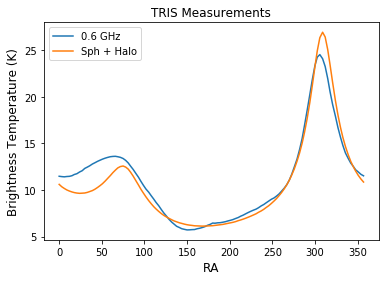

In [32]:
nu = 0.6e9
param_init = [1.6*d, 0.5*d, 0.75*10**(-40), 3*d, 0.5*10**(-41), 2.0]
R_disk, h_disk, j_disk, R_halo, j_halo, T_bkg = param_init

#model = (MD.LineOfSightDisk(TRIS_l[nu], TRIS_b[nu], d, R_disk, h_disk)*j_disk)*(c**2)/(2*k*(nu**2))
model2 = (MD.Spheroid(TRIS_l[nu], TRIS_b[nu], R_disk, h_disk)*j_disk + MD.LineOfSightHalo(TRIS_l[nu], TRIS_b[nu], d, R_halo)*j_halo)*(c**2)/(2*k*(nu**2))

#residuals = TRIS_Tgal[nu] - model
plt.plot(sc600.ra, TRIS_Tgal[nu], label='0.6 GHz')
#plt.plot(sc600.ra, model, label='Disk + Halo')
plt.plot(sc600.ra, model2, label='Sph + Halo')
#plt.plot(sc600.ra, residuals, label='Residuals')
plt.title('TRIS Measurements', fontsize=12)
plt.xlabel('RA', fontsize=12)
plt.ylabel('Brightness Temperature (K)', fontsize=12)
plt.legend();

In [ ]:
np.trapz(residuals, x=sc600.ra.value)

In [144]:
idx = np.ravel([aref1,aref2])
print(TRIS600_ra[idx])
print(TRIS600_Tb[idx])
print(TRIS600_Tbsig[idx])


['10h00m' '20h23m']
[ 9.39  28.193]
[0.    0.015]


## Visualize MCMC results ##
These MCMC results seek to find the largest halo that would be consistent with the data. This can later be used to compare the result with the EDGES survey results.

In [133]:
samples = np.load("TRIS_disk+halo.npz")['samples']
samples = samples[:,500:,:]
print(samples.shape)

ndim=5
samples_reshape = samples.reshape((-1, ndim))
print(samples_reshape.shape)


samples_reshape[:,0] = np.log10(samples_reshape[:,0])
samples_reshape[:,1] = np.log10(samples_reshape[:,1])
samples_reshape[:,2] = np.log10(samples_reshape[:,2])
samples_reshape[:,3] = np.log10(samples_reshape[:,3])
samples_reshape[:,4] = np.log10(samples_reshape[:,4])

if np.any(np.isnan(samples_reshape)==True):
    print("there are nans")

(200, 3500, 5)
(700000, 5)


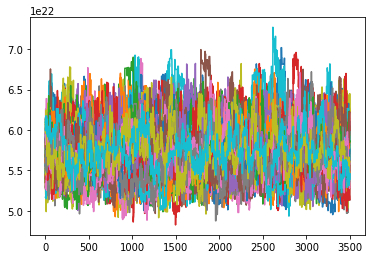

In [121]:
plt.figure()
for i in range(100):
    plt.plot(samples[i,:,0])

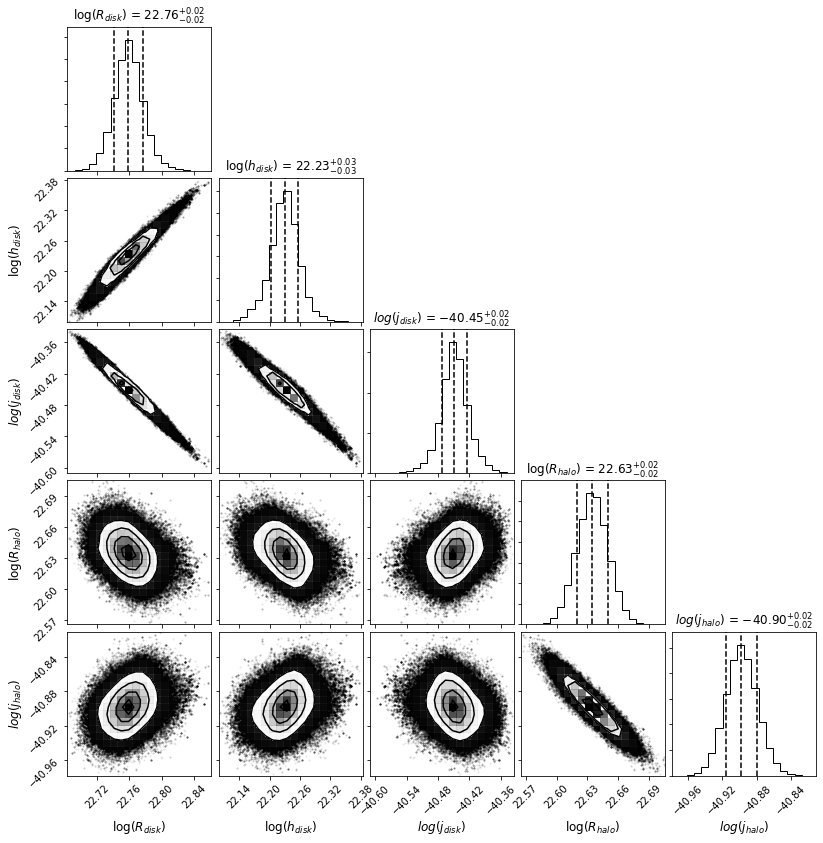

In [122]:
fig = corner.corner(samples_reshape, labels=["log($R_{disk})$","log($h_{disk})$","$log(j_{disk})$","log($R_{halo})$","$log(j_{halo})$"],
                    label_kwargs={"fontsize": 12}, show_titles=True, title_kwargs={"fontsize": 12},
                    quantiles=[0.16,0.5,0.84])

plt.savefig('notes/corner_TRIS_disk+halo.jpg')

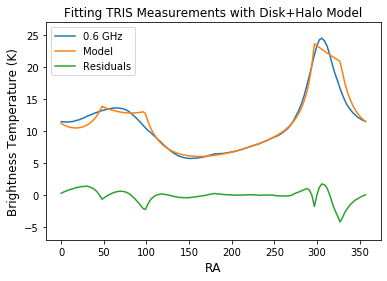

In [135]:
R_disk = 10**np.percentile(samples_reshape[:,0], 50)
h_disk = 10**np.percentile(samples_reshape[:,1], 50)
j_disk = 10**np.percentile(samples_reshape[:,2], 50)
R_halo = 10**np.percentile(samples_reshape[:,3], 50)
j_halo = 10**np.percentile(samples_reshape[:,4], 50)

model = (MD.LineOfSightDisk(TRIS_l[nu], TRIS_b[nu], d, R_disk, h_disk)*j_disk + MD.LineOfSightHalo(TRIS_l[nu], TRIS_b[nu], d, R_halo)*j_halo)*(c**2)/(2*k*(nu**2))
#model = (MD.Spheroid(TRIS_l[nu], TRIS_b[nu], R_disk, h_disk)*j_disk + MD.LineOfSightHalo(TRIS_l[nu], TRIS_b[nu], d, R_halo)*j_halo)*(c**2)/(2*k*(nu**2))

#hp.mollview(MD.Spheroid(l, b, R_disk, h_disk))

plt.figure()
residuals = TRIS_Tgal[nu] - model
plt.plot(sc600.ra, TRIS_Tgal[nu], label='0.6 GHz')
plt.plot(sc600.ra, model, label='Model')
plt.plot(sc600.ra, residuals, label='Residuals')
plt.title('Fitting TRIS Measurements with Disk+Halo Model', fontsize=12)
plt.xlabel('RA', fontsize=12)
plt.ylabel('Brightness Temperature (K)', fontsize=12)
plt.legend();
plt.ylim([-7,27])
plt.savefig('notes/residuals_TRIS_disk+halo.jpg')

In [441]:
print(np.log10(d))

22.392485908719074
